In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import gym_sgw
import gym
from gym_sgw.envs.SGWEnv import SGW
from tf_agents.environments import utils

num_iterations = 10000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 10000  # @param {type:"integer"}

train_py_env = SGW()
eval_py_env = SGW()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (100, 80, 50, 20)
action_tensor_spec = tensor_spec.from_spec(train_py_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print(num_actions)
# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
print(dense_layers)
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print(random_policy)

example_environment = tf_py_environment.TFPyEnvironment(SGW())



time_step = example_environment.reset()

print(train_env.time_step_spec())
print(train_env.action_spec())
print(time_step)
random_policy.action(time_step)

#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

compute_avg_return(eval_env, random_policy, num_eval_episodes)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


iterator = iter(dataset)
print(iterator)

2021-07-29 00:43:21.876037: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
4
[<tensorflow.python.keras.layers.core.Dense object at 0x7f01fe9223d0>, <tensorflow.python.keras.layers.core.Dense object at 0x7f01f1811850>, <tensorflow.python.keras.layers.core.Dense object at 0x7f01f1811b20>, <tensorflow.python.keras.layers.core.Dense object at 0x7f01f1811e50>]


2021-07-29 00:43:24.987146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-29 00:43:33.581577: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-29 00:43:33.581625: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gabrielhan): /proc/driver/nvidia/version does not exist
2021-07-29 00:43:33.583037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(121,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(1000., dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32))
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 121), dtype=float32, numpy=
array([[200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
        200., 300., 300., 300., 301., 600., 200., 300., 301., 300., 200.,
        200., 300., 300., 200., 200., 200., 200., 300., 300., 300., 200.,
        200., 300., 300., 300., 300., 300., 

2021-07-29 00:43:37.824219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-29 00:43:37.843856: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1497600000 Hz


In [2]:
#@test {"skip": true}

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 10000: loss = 0.0
step = 10000: Average Return = 0.0
step = 20000: loss = 0.0
step = 20000: Average Return = 0.0
step = 30000: loss = 0.0
step = 30000: Average Return = 0.0
step = 40000: loss = 0.0
step = 40000: Average Return = 0.0
step = 50000: loss = 0.0
step = 50000: Average Return = 100.0
step = 60000: loss = 0.0
step = 60000: Average Return = 100.0
step = 70000: loss = 0.0
step = 70000: Average Return = 100.0
step = 80000: loss = 0.0
step = 80000: Average Return = 0.0
step = 90000: loss = 0.0
step = 90000: Average Return = 100.0
step = 100000: loss = 0.0
step = 100000: Average Return = 0.0
step = 110000: loss = 0.0
step = 110000: Average Return = 0.0
step = 120000: loss = 0.0
step = 120000: Average Return = 0.0
step = 130000: loss = 0.0
step =

ValueError: x and y must have same first dimension, but have shapes (1001,) and (339,)

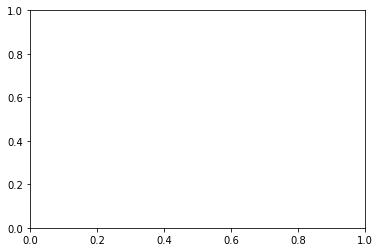

In [5]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
# create_policy_eval_video(agent.policy, "trained-agent")
# agent.save_weights('lovelyweights1')
# eval_py_env.save_weights('lovelyweights2')

from gym_sgw.envs.enums.Enums import Terrains, MapColors, MapObjects
import pygame as pg
pg.init()
game_screen = pg.display.set_mode((1000, 800))
play_area = pg.Surface((10 * 30, 10 * 30))
play_area.fill(pg.color.Color(MapColors.play_area.value))
game_screen.fill(pg.color.Color(MapColors.game_screen.value))

time_step = eval_env.reset()
while not time_step.is_last():
    for event in pg.event.get():
        if event.type == pg.KEYDOWN:
            if event.key == pg.K_ESCAPE:
                game_exit = True
                pg.quit()
            if event.key in [pg.K_SPACE, pg.K_KP_ENTER, pg.K_UP, pg.K_DOWN, pg.K_LEFT, pg.K_RIGHT,pg.K_w, pg.K_a, pg.K_s, pg.K_d, pg.K_0, pg.K_1, pg.K_2, pg.K_3]:
                action_step = random_policy.action(time_step)
                print("action",int(action_step.action))
                time_step = eval_env.step(action_step.action)
                print("reward",int(time_step.reward))
                # eval_env._env._envs[0].step(int(action_step.action))
                s = list(time_step.observation)[0]
                # print("hey there im actually kinda important:")
                # print(eval_env._env._envs)
                # print(eval_env._env._envs[0])
                # print(eval_env._env._envs[0].get_map())
                map_text = eval_env._env._envs[0].get_map()
                # print(eval_env.pyenv.get_map())
                ahh = []
                for x in range(10):
                        z = s[x*10:(x+1)*10]
                        ahh.append(z)                
                # print(ahh)
                for r_ in range(10):
                    for c_ in range(10):
                        cell = int(str(int(ahh[r_][c_]))[0])
                        if cell == Terrains.none:
                            cell_color = pg.color.Color(MapColors.black_tile.value)
                        elif cell == Terrains.out_of_bounds:
                            cell_color = pg.color.Color(MapColors.black_tile.value)
                        elif cell == Terrains.wall:
                            cell_color = pg.color.Color(MapColors.wall_tile.value)
                        elif cell == Terrains.floor:
                            cell_color = pg.color.Color(MapColors.floor_tile.value)
                        elif cell == Terrains.mud:
                            cell_color = pg.color.Color(MapColors.mud_tile.value)
                        elif cell == Terrains.fire:
                            cell_color = pg.color.Color(MapColors.fire_tile.value)
                        elif cell == Terrains.hospital:
                            cell_color = pg.color.Color(MapColors.hospital_tile.value)
                        else:
                            raise ValueError('Invalid cell terrain while rendering game image.')

                        # Draw the rectangle with the right color for the terrains
                        # rect is play area, color, and (left point, top point, width, height)
                        pg.draw.rect(play_area, cell_color, (c_ * 30, r_ * 30,
                                                                30, 30))
                        game_screen.blit(play_area, play_area.get_rect())

                        # Add in the cell value string
                        pg.font.init()

                        cell_font = pg.font.SysFont(pg.font.get_default_font(), 20)
                        
                        text_surf = cell_font.render(map_text[r_][c_], True, pg.color.Color(MapColors.text.value))
                        play_area.blit(text_surf, ((c_ * 30) + 30 // 2,
                                                        (r_ * 30) + 30 // 2))
                        pg.display.update()


action 1
reward -1
action 1
reward -2
action 1
reward -2
action 2
reward -3
action 3
reward -4
action 0
reward -4
action 3
reward -5
action 2
reward -5
action 1
reward -20
action 0
reward -20
action 3
reward -21
action 3
reward -26
action 3
reward -26
action 3
reward -26
action 2
reward -24
action 2
reward -22
action 1
reward -37
action 1
reward -37
action 3
reward -37
action 3
reward -37
action 2
reward -37
action 3
reward -37
action 2
reward -37
action 0
reward -37


In [ ]:
# create_policy_eval_video(random_policy, "random-agent")

# create_policy_eval_video(agent.policy, "trained-agent")
# agent.save_weights('lovelyweights1')
# eval_py_env.save_weights('lovelyweights2')

from gym_sgw.envs.enums.Enums import Terrains, MapColors, MapObjects
import pygame as pg
pg.init()
game_screen = pg.display.set_mode((1000, 800))
play_area = pg.Surface((10 * 30, 10 * 30))
play_area.fill(pg.color.Color(MapColors.play_area.value))
game_screen.fill(pg.color.Color(MapColors.game_screen.value))

time_step = eval_env.reset()
while not time_step.is_last():
    for event in pg.event.get():
        if event.type == pg.KEYDOWN:
            if event.key == pg.K_ESCAPE:
                game_exit = True
                pg.quit()
            if event.key in [pg.K_SPACE, pg.K_KP_ENTER, pg.K_UP, pg.K_DOWN, pg.K_LEFT, pg.K_RIGHT,pg.K_w, pg.K_a, pg.K_s, pg.K_d, pg.K_0, pg.K_1, pg.K_2, pg.K_3]:
                action_step = random_policy.action(time_step)
                print("action",int(action_step.action))
                time_step = eval_env.step(action_step.action)
                print("reward",int(time_step.reward))
                eval_env._env._envs[0].step(int(action_step.action))
                s = list(time_step.observation)[0]
                # print("hey there im actually kinda important:")
                # print(eval_env._env._envs)
                # print(eval_env._env._envs[0])
                # print(eval_env._env._envs[0].get_map())
                map_text = eval_env._env._envs[0].get_map()
                # print(eval_env.pyenv.get_map())
                ahh = []
                for x in range(10):
                        z = s[x*10:(x+1)*10]
                        ahh.append(z)                
                # print(ahh)
                for r_ in range(10):
                    for c_ in range(10):
                        cell = int(str(int(ahh[r_][c_]))[0])
                        if cell == Terrains.none:
                            cell_color = pg.color.Color(MapColors.black_tile.value)
                        elif cell == Terrains.out_of_bounds:
                            cell_color = pg.color.Color(MapColors.black_tile.value)
                        elif cell == Terrains.wall:
                            cell_color = pg.color.Color(MapColors.wall_tile.value)
                        elif cell == Terrains.floor:
                            cell_color = pg.color.Color(MapColors.floor_tile.value)
                        elif cell == Terrains.mud:
                            cell_color = pg.color.Color(MapColors.mud_tile.value)
                        elif cell == Terrains.fire:
                            cell_color = pg.color.Color(MapColors.fire_tile.value)
                        elif cell == Terrains.hospital:
                            cell_color = pg.color.Color(MapColors.hospital_tile.value)
                        else:
                            raise ValueError('Invalid cell terrain while rendering game image.')

                        # Draw the rectangle with the right color for the terrains
                        # rect is play area, color, and (left point, top point, width, height)
                        pg.draw.rect(play_area, cell_color, (c_ * 30, r_ * 30,
                                                                30, 30))
                        game_screen.blit(play_area, play_area.get_rect())

                        # Add in the cell value string
                        pg.font.init()

                        cell_font = pg.font.SysFont(pg.font.get_default_font(), 20)
                        
                        text_surf = cell_font.render(map_text[r_][c_], True, pg.color.Color(MapColors.text.value))
                        play_area.blit(text_surf, ((c_ * 30) + 30 // 2,
                                                        (r_ * 30) + 30 // 2))
                        pg.display.update()


NameError: name 'eval_env' is not defined